In [1]:
from fastai.tabular import *

In [2]:
def get_valid_idx(train_df):
    train_n = len(train_df)

    valid_pct = 0.2
    valid_size = int(valid_pct * train_n)
    valid_idx = np.random.choice(train_n, valid_size, replace=False)
    return valid_idx

In [3]:
def load_data(fn):
    data = pd.read_csv(fn)
    return data

In [4]:
train_df = load_data("train_df.csv")
test_df = load_data("test_df.csv")

In [5]:
# path = untar_data(URLs.ADULT_SAMPLE)

# df = pd.read_csv(path/'adult.csv')
# n = len(df)

# # Create a fake test set
# test_pct = 0.8
# test_size = int(test_pct * n)
# test_idx = np.random.choice(n,test_size,replace=False)

# test_df = df.iloc[test_idx]

# train_df = df.loc[~df.index.isin(test_idx)]

# train_df.to_csv("train_df.csv",index=None)
# test_df.to_csv("test_df.csv",index=None)

In [6]:
valid_idx = get_valid_idx(train_df)

procs = [FillMissing, Categorify, Normalize]
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status',
             'occupation', 'relationship', 'race', 'sex', 'native-country']

path = Path()
data = TabularDataBunch.from_df(path, train_df,
    dep_var, valid_idx=valid_idx, procs=procs,cat_names=cat_names,
    test_df=test_df)

learn = tabular_learner(data, layers=[200,100],ps=[0.10,0.05], emb_szs={'native-country': 10}, metrics=accuracy)

learn.fit_one_cycle(5, 1e-1 / 2)

epoch,train_loss,valid_loss,accuracy,time
0,0.389287,0.361814,0.833333,00:10
1,0.345307,0.369235,0.823349,00:01
2,0.337528,0.360519,0.827957,00:01
3,0.320970,0.356175,0.828725,00:01
4,0.308207,0.344176,0.837942,00:01


In [26]:
test = TabularList.from_df(test_df, path=path, cat_names=cat_names, cont_names=cont_names)

In [27]:
learn.data.add_test(test)

In [28]:
pred,y = learn.get_preds(ds_type=DatasetType.Test)

In [35]:
preds = []
n_sample = 5

for i in range(n_sample):
    pred,y = learn.get_preds(ds_type=DatasetType.Test)
    pred = pred[None]
    preds.append(pred)

In [38]:
preds = torch.cat(preds)

In [39]:
def entropy(probs):
    """Return the prediction of a T*N*C tensor with :
        - T : the number of samples
        - N : the batch size
        - C : the number of classes
    """
    probs = to_np(probs)
    prob = probs.mean(axis=0)

    entrop = - (np.log(prob) * prob).sum(axis=1)
    return entrop

In [41]:
test_df["entropy"] = entropy(preds)

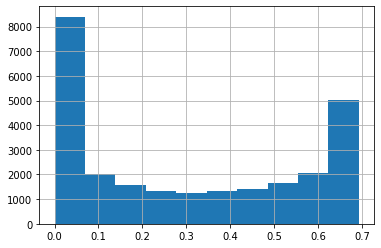

In [43]:
test_df

In [8]:
from fastai.callback import Callback
import streamlit as st

class ProgressCallback(Callback):
    
    def __init__(self):
        super().__init__()
        self.text_slot = st.empty()
        self.bar = st.progress(0)
    
    def on_train_begin(self,**kwargs):
        n_epochs = kwargs["n_epochs"]
        self.text_slot.text("Processing batches ...")
        self.n_epochs = n_epochs
        self.step = 1 / n_epochs
        
    def on_epoch_end(self,**kwargs):
        epoch = kwargs["epoch"]
        progress = (epoch+1) * self.step
        self.text_slot.text(f"Processing batch {(epoch+1)}/{self.n_epochs}")
        self.bar.progress(progress)
        
    def on_train_end(self,**kwargs):
        st.write("Trainig complete !")
        
cb = ProgressCallback()
learn.fit_one_cycle(5,1e-2,callbacks=cb)

epoch,train_loss,valid_loss,accuracy,time
0,0.311233,0.317032,0.844854,00:01
1,0.312171,0.319346,0.850998,00:01
2,0.309443,0.319603,0.850230,00:01
3,0.298392,0.324375,0.849462,00:01
4,0.295911,0.319816,0.844854,00:01


In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,figsize=(20,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred,)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum()
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return fig

In [16]:
pred,y = learn.get_preds()
pred = pred.argmax(dim = 1)
classes = learn.data.train_ds.y.classes

In [17]:
_, c = np.unique(classes, return_inverse=True)

In [30]:
cm = confusion_matrix(y,pred,c)

In [32]:
cm = cm / cm.sum()

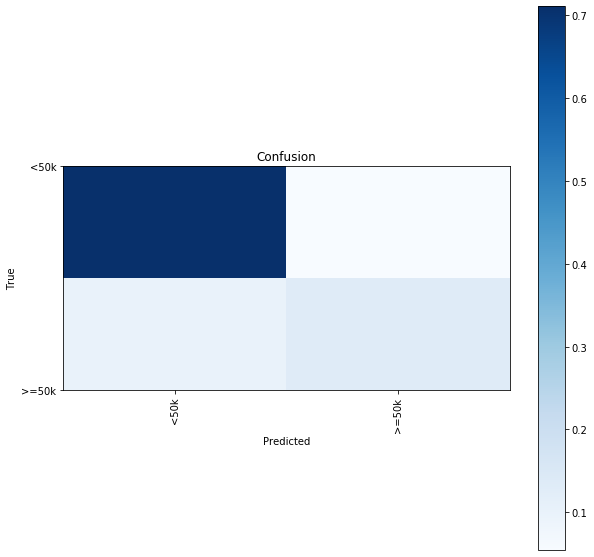

In [33]:
from IPython.display import display, HTML
title = "Confusion"
fig,ax=plt.subplots(1,1,figsize=(10,10))
im=ax.imshow(cm, cmap="Blues")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title(f"{title}")
ax.set_xticks(range(learn.data.c))
ax.set_yticks(range(learn.data.c))
ax.set_xticklabels(learn.data.classes, rotation='vertical')
ax.set_yticklabels(learn.data.classes)
fig.colorbar(im)